# Simulator

This notebook goes over the basic usage of the simulator class interface to running some basic simulations of a Smoluchowski eqution, and shows how you can extend the functionality to work for a new system by defining a force function.

After going through this notebook you should understan how to perform the following taasks using this package:
- Initialize an instance of the FPE simulator class by defining a configuration dictionary
- Run a simulation of the model system for a fixed amount of time in a static environment
- Run a simulation of the model system in a dynamic environment
- Calculate physical quantities, like work input, for the model system
- Define a new, custom model, and use the simulator interface to run the model

In [22]:
# Import necessary requirements
import numpy as np
from fokker_planck.simulator.simulator import HarmonicTranslationSimulator
from fokker_planck.types.basetypes import BoundaryCondition

# Define the required configuration for the system, we will look at a domain of
# -2 -> +2 with a discretization of 0.01 in space and 0.001 in time
config = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.001,
    "x_min": -2,
    "x_max": 2,
    "boundary_cond": BoundaryCondition.Periodic
}

# An alternate, but equivalent configuration would specify, instead of x_min
# and x_max, the range of x values directly:
config_alt = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.0001,
    "x_array": np.arange(-3, 3, 0.01)
}


In [23]:
# Now we can initialize the simulator class with the configuration as well
# as a few parameters that are intended to be used for dynamic potentials

harmonic_sim = HarmonicTranslationSimulator(config, trap_init=0, trap_fin=0.1, trap_strength=4.0)

# And then run the simulation
sim_result = harmonic_sim.run_simulation(tau=1.0)

/Users/stevelarge/Research/FokkerPlanck/fokker_planck/Integrator.py:396: RuntimeWarning: overflow encountered in double_scalars
  force_function(self.x_array[i] + 0.5 * self.dx, force_params) * half_prob[i + 1]
/Users/stevelarge/Research/FokkerPlanck/fokker_planck/Integrator.py:358: RuntimeWarning: overflow encountered in double_scalars
  - (self.D * delta_t / self.dx)
/Users/stevelarge/Research/FokkerPlanck/fokker_planck/Integrator.py:359: RuntimeWarning: overflow encountered in double_scalars
  * (halfFlux[index+1] - halfFlux[index])
/Users/stevelarge/Research/FokkerPlanck/fokker_planck/Integrator.py:292: RuntimeWarning: overflow encountered in multiply
  sum(energy_function(self.x_array, force_params_pre) * self.prob) * self.dx
/Users/stevelarge/Research/FokkerPlanck/fokker_planck/Integrator.py:292: RuntimeWarning: invalid value encountered in double_scalars
  sum(energy_function(self.x_array, force_params_pre) * self.prob) * self.dx
/Users/stevelarge/Research/FokkerPlanck/fokker_pl

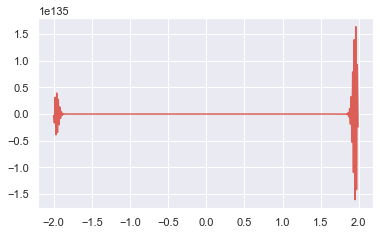

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='hls')

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

for prob in sim_result.prob_tracker[2:]:
    ax.plot(sim_result._sim.fpe.x_array, prob)
    break

In [26]:
from fokker_planck.Integrator import FokkerPlank1D
import fokker_planck.forceFunctions as ff

x_array = np.arange(-3, 3, 0.01)
fpe = FokkerPlank1D(1.0, 0.00025, 0.01, x_array)
fpe.initialize_probability(0, 0.25)
prob_tracker = []

for _ in range(100):
    prob_tracker.append(fpe.prob.copy())
    fpe.integrate_step(([4.0, 0]), ff.harmonic_force)

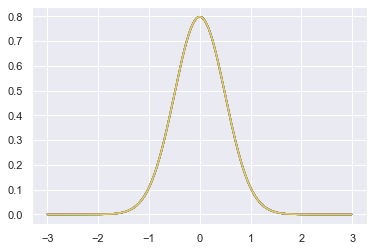

In [28]:
fig, ax = plt.subplots(1, 1)

for prob in prob_tracker[::5]:
    ax.plot(x_array, prob)
